# Klassifikationsverfahren

## Ein `jupyter`-Tutorial mit `python` und `scikit-learn`

**Ingo Scholtes**  
*4. Juli 2018*  

Dieses an Bachelor-Studenten gerichtete `jupyter`-Tutorial begleitet meine 15-minütige Einführung in Klassifikationsverfahren. Es erlaubt die praktische Anwendung der vorgestellten Methoden mit Hilfe des `python`-Pakets für maschinelles Lernen `scikit-learn`.

Um das Tutorial so einfach und anschaulich wie möglich zu gestalten, müssen wir zunächst einige Pakete importieren. Ausserdem definieren wir drei Hilfsfunktionen, die für die visuelle Darstellung unserer Beispieldaten sorgen. Ich beschränke mich auf eine kurze Erläuterung der jeweiligen Methode. Für das Verständnis des beschriebenen Klassifikationsverfahrens ist es nicht notwendig, die technische Details dieser Methoden zu verstehen.

In [1]:
%matplotlib inline

# Das Paket numpy enthält mathematische Methoden, die wir für unser Tutotorial benötigen
import numpy as np

# Das paket matplotplib erlaubt es uns, Plots zu erstellen. Der Parameter inline, den wir in der ersten
# Zeile dieser Zelle setzen, sorgt dafür, dass die Plots direkt im jupyter-Notebook dargestellt werden.
import matplotlib.pyplot as plt

# Das Paket sklearn implementiert eine Reihe von Verfahren des maschinellen Lernens, darunter auch 
# Klassifikationsverfahren. Für unser Tutorial importieren wir den naiven Bayes-Klassifikator, mit der Annahme 
# unabhängiger und normalverteilter Features (Details hierzu werden unten erklárt).
from sklearn.naive_bayes import GaussianNB

# Das Paket sklearn enthält auch einige Beispieldatensätze, die wir zum Testen von Klassifikationsverfahren
# verwenden können und die wir im folgenden importieren. Wir verwenden insbesondere einen Datensatz mit Pixelbildern,
# die verschiedene Zahlen darstellen.
from sklearn import datasets

# Diese Hilfsmethode erlaubt es uns einzelne Pixelbilder aus dem Beispieldatensatz direkt im jupyter-Notebook darzustellen. 
# Darüberhinaus können wir den Parameter f verwenden, um zweidimensionale Features visuell darzustellen.
def plotImage(img, f = None):
    font = {'color':  'red',
        'weight': 'bold',
        'size': 16,
        }    
    plt.imshow(img, cmap=plt.cm.gray_r, interpolation='none')    
    plt.xticks(range(8))
    plt.yticks(range(8))
    if type(f) is np.ndarray:
        str_label = '(' + str(np.round(f[1], 2)) + ', ' + str(np.round(f[0], 2)) + ')'
        plt.scatter(f[1], f[0], 280, 'red', 'x')
        plt.axhline(y=f[0], color='red', linewidth=3)
        plt.axvline(x=f[1], color='red', linewidth=3)
        plt.text(3, 4, str_label, fontdict=font)
    plt.grid()
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show()


# Diese Hilfsmethode erzeugt ein rechteckiges Panel mit Pixelbildern, welche verschiedene Zahlen darstellen.
# Wir können einen Anteil dieser Bilder entsprechend der abgebildeten Zahlen farbig markieren 
# (bspw. um die Trainingsdaten hervorzuheben).
def plotDigitPanel(digits, indices, color_frac):
    for index, image in enumerate(digits.images[indices]):
        plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), index+1)
        plt.axis('off')
        if index < int(color_frac * n):            
            alpha = 1.0
            if digits.target[indices[index]] == 3:
                plt.imshow(image, cmap=plt.cm.Blues, interpolation='nearest', alpha=alpha)
            elif digits.target[indices[index]] == 6:
                plt.imshow(image, cmap=plt.cm.Reds, interpolation='nearest', alpha=alpha)
            elif digits.target[indices[index]] == 5:
                plt.imshow(image, cmap=plt.cm.YlOrBr, interpolation='nearest', alpha=alpha)
        else:
                plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest', alpha=0.5)
    plt.show()


# Diese Hilfsmethode erzeugt einen zweidimensionalen Scatter-Plot mit Features. Wir können wieder 
# einen Anteil dieser Werte entsprechend der jeweils zugehörigen Zahl farbig hervorheben, bspw. um 
# die Trainingsdaten zu visualisieren.
def plotData(data, classes, color_frac=1.0):
    h = 0.02    
    alpha = 0.8
    s = 60  
    
    x_min, x_max = 2.7, 4.5
    y_min, y_max = 2.7, 4.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    colored = int(len(data)*color_frac)    
    plt.scatter(data[:, 0][:colored], data[:, 1][:colored], c=classes[:colored], cmap = plt.cm.coolwarm, s=s, edgecolors='k')        
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.tick_params(axis='both', which='major', labelsize=18)    
    plt.show()

## Extrahieren der Features

Ziel unseres Tutorials ist es, in einer Menge von Pixelbildern welche verschiedene handgeschriebene Zahlen darstellen automatisch die abgebildete Zahl zuzuordnen. Hierzu nutzen wir ein sogenanntes Klassifikationsverfahren, d.h. wir ordnen unseren Daten (Pixelbilder mit 8x8 Pixeln) automatisch die korrekte Klasse (d.h. die hierin abgebildete) zu.

Das Paket `scikit-learn` enthält einen Datensatz, den wir verwenden können, um dieses Problem zu illustrieren. Wir können ihn folgendermassen laden:

In [2]:
digits = datasets.load_digits()

Schauen wir uns an, welche Struktur diese Daten haben. Bei der Variable `digits` handelt es sich um ein `dictionary`, welches mehrere Einträge enthält. Der Eintrag `digits.DESCR` enthält zum Beispiel eine Beschreibung des Datensatzes:

In [3]:
print(digits.DESCR)

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

Für uns relevant sind die beiden Einträge `digits.images` und `digits.target`. Bei `digits.images` handelt es sich um eine Liste von zweidimensionalen 8x8 Arrays, welche die Pixelwerte der jeweiligen Bilder beinhalten. Die Pixelwerte von 0 bis 16 repräsentieren verschiedene Graustufen, wobei 0 weiss bedeutet und 16 schwarz. Wir können bspw. das zweidimensionale Array des Eintrag mit Index 15 ausgeben:

In [4]:
print(digits.images[15])

[[ 0.  5. 12. 13. 16. 16.  2.  0.]
 [ 0. 11. 16. 15.  8.  4.  0.  0.]
 [ 0.  8. 14. 11.  1.  0.  0.  0.]
 [ 0.  8. 16. 16. 14.  0.  0.  0.]
 [ 0.  1.  6.  6. 16.  0.  0.  0.]
 [ 0.  0.  0.  5. 16.  3.  0.  0.]
 [ 0.  1.  5. 15. 13.  0.  0.  0.]
 [ 0.  4. 15. 16.  2.  0.  0.  0.]]


Der Eintrag `digits.target` enthält die jeweils tatsächlich dargestellte Zahl. Wir sehen, dass das Pixelbild mit Index 15 eine **5** darstellen soll:

In [5]:
print(digits.target[15])

5


Tatsächlich können wir die Form einer handgeschriebenen **5** bereits vage im zweidimensionalen Array (oben dargestellt in Matrix-Form) erkennen. Deutlich  einfacher ist dies jedoch, wenn wir die Pixeldaten tatsächlich als Graustufenbild darstellen. Hierzu können wir unsere Hilfsmethode `plotImage` verwenden. Wir müssen einfach nur unser zweidimensionales Array von Pixelwerten übergeben:

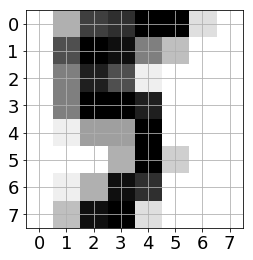

In [6]:
plotImage(digits.images[15])

Wir wissen also nun, wie wir auf unsere Testdaten zugreifen können, und wie wir diese darstellen können. Beginnen wir nun also mit der automatischen Klassifikation dieser Daten. D.h. wir wollen in den Bildaten `digits.images` automatisch erkennen, welche Zahl dargestellt wird. Mit der Variable `digits.target` können wir dann überprüfen ob unsere Klassifikation korrekt ist.

Da jedes unseres Bilder 64 Pixelwerte (im Bereich von 0-16) enthält, haben wir es mit einem hochdimensionalen Problem zu tun. Denn jedes unseres Bilder ist damit ja ein Punkt in einem 64-dimensionalen Raum. Ein erster Schritt im Einsatz maschineller Lernverfahren ist üblicherweise, die Dimensionalität des Problems zu reduzieren. Denn zum einen können hochdimensionale Daten zu Skalierbarkeitsproblemen führen. Zum anderen ist ein hochdimensionaler Raum dann problematisch, wenn wir es mit verhältnismässig wenigen Datenpunkten zu tun haben (was zu einem hohen Risiko des *Overfittings* führt).

Diese Problemen können wir vermeiden, indem wir die Dimensionalität unseres Problems reduzieren. Im Englischen nennen wir diesen Prozess "dimensionality reduction", "feature extraction", oder "embedding". Die letzten beiden dieser Begriffe fassen, dass wir unsere hochdimensionalen Daten in einen niedrigdimensionaleren Raum einbetten wollen, bzw. dass wir für jedes unseres 8x8 Pixelbilder eine kleinere Anzahl numerischer **Merkmale** oder **Features** extrahieren möchten.

Wir können uns eine Reihe von Merkmalen vorstellen, die wir in einem 8x8 Pixelbild berechnen können: die Anzahl der nicht-weissen Pixel, die durschnittlichen Helligkeitswerte, etc. Im folgenden verwenden wir einen sehr einfachen Ansatz, indem wir das **Massezentrum** der Pixelwerte berechnen, d.h. wir berechnen das gewichtete Mittel der Pixelkoordinaten, wobei der jeweilige Helligkeitswert von 0-16 an einer Position `digits.images[i,j]` als *Gewicht* der Koordinate (i,j) in die gewichtete Mittelwertsberechnung eingeht. Durch die Berechnung der mittleren Koordinaten in der x- und y-Dimension projezieren wir also unser 8x8 Pixelbild in einen zweidimensionalen euklidischen Raum.

Wir können diese Projektion mit folgender Methode erledigen. Als Parameter übergeben wir das zweidimensionale Array mit Pixelwerten. Als Rückgabewert erhalten wir die Koordinaten des *Schwerpunkts* der Pixelwerte:

In [7]:
def project(pixels):
    mass = 0
    for i in range(8):
        for j in range(8):
            mass += pixels[i,j] * np.array([i,j])
    return mass/np.sum(pixels)

Wir können diese Methode nun auf unser Beispielbild anwenden:

In [8]:
d = project(digits.images[15])
print(d)

[2.97878788 2.93333333]


Mit unserer Hilfsmethode `plotImage` können wir den Schwerpunkt der Pixelwerte direkt im Bild darstellen:

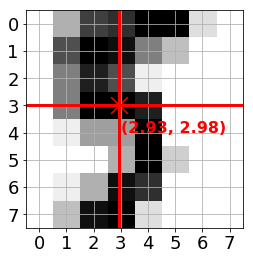

In [9]:
plotImage(digits.images[15], d)

Wir können dies nun mit dem Bild einer anderen **5** vergleichen. Da sich trotz der gleichen abgebildeten Zahl die Handschrift leicht unterscheidet erhalten wir natürlich auch einen anderen Schwerpunkt. Dieser liegt im Beispiel etwas weiter rechts unten im Bild:

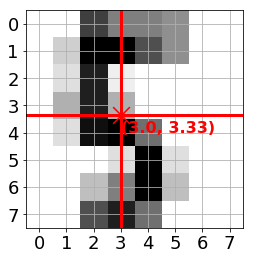

In [10]:
plotImage(digits.images[25], project(digits.images[25]))

Der Einfachheit halber wollen wir uns im folgenden auf eine Teilmenge der im `digits`-Datensatz enthaltene Bildaten beschränken. Und zwar verwenden wir insgesamt 81 zufällig ausgewählte Bilder, die entweder eine **3**, **5** oder eine **6** darstellen. Wir speichern die Featurewerte dieser zufällig ausgewählten Bilder, sowie die korrekten Klassen in den beiden Variablen `data` und `classes`.

In [11]:
n = 81

indices = np.where( (digits.target==6) | (digits.target==3) | (digits.target==5))[0]
indices = np.random.choice(indices, n)
data = np.array([ project(d) for d in digits.images[indices]])
classes = digits.target[indices]

Nun können wir unsere oben definierte Hilfsmethode `plotDigitPanel` verwenden, um die Daten visuell darzustellen. Zunächst generieren wir einen Plot, in dem alle 81 ausgewählten Bilder dargestellt. Wir färben jedes dieser Bilder entsprechend seiner Klasse, d.h. alle Bilder, die eine **5** zeigen färben wir gelb wohingegen Bilder, die eine **3** oder **6** zeigen blau bzw. rot gefärbt werden. Wichtig: diese Färbung dient nur der besseren Darstellung, d.h. wir verändern **nicht** die zugrundeliegenden Pixelwerte (die ja eh nur Graustufen enthalten).

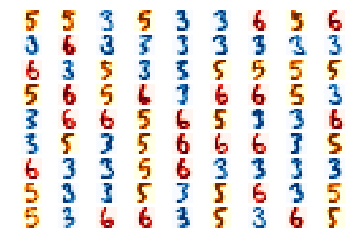

In [12]:
plotDigitPanel(digits, indices, 1)

Als nächstes wollen wir die Verteilung der Featurwerte in einem Scatter-Plot darstellen. Hierzu können wir die Hilfsmethode `plotData` verwenden. Jede Zahl im Panel oben entspricht nun einem Punkt in dem zweidimensionalen Featurespace. Wir färben die einzelnen Punkte wieder entsprechend der im Bild dargestellten Zahl.

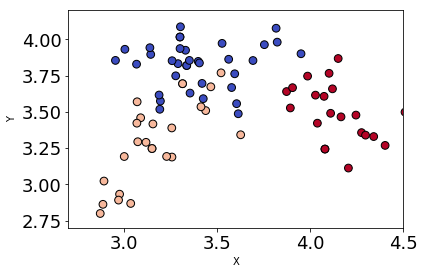

In [13]:
plotData(data, classes, 1)

## Klassifikationsverfahren

Wir wissen nun also, wie wir unsere Bilder mit je 64 Pixelwerten in einen zweidimensionalen euklidischen Featurespace $\mathbb{F}=\mathbb{R}^2$ einbetten können. Wir suchen nun einen sogenannten Klassifikator, der Punkte in diesem Feauturespace auf die jeweils korrekte *Klasse*, in unserem Beispiel sind dies die abgebildeten Zahlen $\{3, 5, 6\}$, abbildet. Wir benötigen also eine Funktion:

$C:\mathbb{R}^2 \rightarrow \{3, 5, 6\} $

Es gibt eine Reihe unterschiedlicher Klassifikationsverfahren, die uns eine solche Funktion liefern können. Grundlegend unterscheiden wir dabei zwischen **überwachten** und **nicht überwachten** Klassifikationsverfahren.

**Nicht-überwachte Verfahren** basieren auf der Erkennung von Mustern in der Verteilung der Features. Ein wesentlicher Vorteil dieser Verfahren ist, dass sie keine Trainingsdaten benötigen in denen die korrekten Klassen bereits bekannt sind. Sie extrahieren also die Klassenstruktur direkt aus der Verteilung der Features im Featurespace $\mathbb{F}$. Beispiele für nicht-überwachte Verfahren sind k-means Clustering oder Graph Clustering (welches wir in unserer Einführung kurz illustrieren). 

Im Plot oben können wir bereits erahnen wie diese Methoden funktionieren: Denn die Feature-Werte der Bilder, die eine bestimmte Zahl darstellen (bspw. die roten Punkte, die zur Zahl **6** gehören) bilden einen Cluster von Punkten, deren Abstand zueinander kleiner ist als zu den Features anderer Zahlen. Diese Clusterstruktur können wir dann zur Klassifikation verwenden.

Im Gegensatz zu diesen Clusterverfahren basieren **überwachte Verfahren** auf Trainingsdaten, in denen die korrekten Klassen bekannt sind. Wir nutzen also von Hand gelabelte Beispiele um einen generalisierbaren Klassifikator zu erlernen, welchen wir dann für die Klassifikation unbekannter Daten verwenden können. Beispiele für überwachte Verfahren sind Support Vector Machines, Entscheidungsbäume oder das im folgenden erläuterte Verfahren der naiven Bayes-Klassifikation.

Schauen wir uns an, wie überwachte Klassifikationsverfahren funktionieren. Hierzu definieren wir zunächst einen Trainingsdatensatz, d.h. eine Menge von Daten für die wir sowohl die Features, wie auch die zugehörige Klasse kennen. In unserem Beispiel besteht unser Trainingsdatensatz also aus einer Menge von Tupeln $(f,k)$ mit $f \in \mathbb{R}^2$ und $k \in \{3, 5, 6\}$. Auf Grundlage dieser Trainingsdaten wollen wir nun einen Klassifikator $C$ finden, der auf Basis der Features bisher unbekannter Bilder automatisch die korrekte Klasse zuweist.

Im folgenden verwenden wir 75 % der Daten als Trainingsdaten, d.h. wir gehen davon aus dass die Klassen für drei Viertel (ca. 60) unserer 81 Bilder bekannt sind. Solche Daten erhalten wir beispielsweise indem wir einem Anteil der Bilder manuell die korrekten Zahlen zuweisen.

In [14]:
training_frac = 0.75
training_samples = int(training_frac*n)

Wir können unsere Hilfsmethode verwenden, um die Bilder im Trainingsdatensatz farbig hervorzuheben, wobei wir diejenigen Bilder für die wir die eigentliche Klassifikation durchführen wollen grau darstelen:

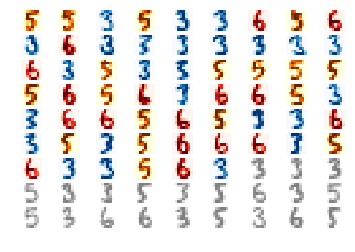

In [15]:
plotDigitPanel(digits, indices, training_frac)

Nun können wir die Trainingsdaten, sowie die Daten für die wir die Klassifikation durchführen wollen im Feature-Space darstellen. Hierbei markieren wir die Trainingsdaten wiederum als farbige Punkte, wobei die Features von Bildern mit unbekannter Klasse als schwarze Kreuze dargestellt werden:

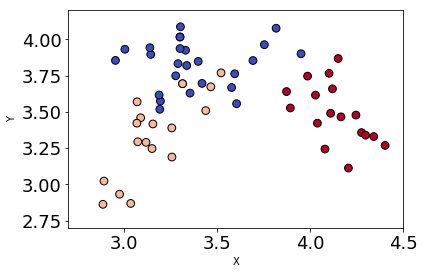

In [16]:
plotData(data, classes, color_frac=training_frac)

## Überwachte Verfahren: Naive Bayes Klassifikation

Wie finden wir also nun den gewünschten Klassifikator $C$, der den schwarzen Kreuzen im obigen Plot die korrekte Klasse, und damit die korrekte Farbe, zuweist?

Im folgenden führen wir ein einfaches **statistisches Klassifikationsverfahren** ein, die sogenannte naive Bayes Klassifikation. Grundlegende Idee statistischer Klassifikationsverfahren ist es, auf Grundlage von Trainingsdaten eine bedingte Wahrscheinlichkeit 

$P(C=k | f)$ 

zu "erlernen", d.h. die wir wollen die Wahrscheinlichkeiten berechnen, dass ein Bild mit bekannten Features $f$ zu verschiedenen Klassen $k$ gehört.

Wenn wir diese Wahrscheinlichkeiten kennen, können wir einen Klassifikator $C: \mathbb{R}^2 \rightarrow \mathbb{C}$ folgendermassen definieren:

$C(f) := \text{arg max}_{k \in \mathbb{C}} P(C=k|f)$

Das heisst, dass wir einem Bild mit Feature $f$ diejenige Klasse zuweisen, welche die höchste Wahrscheinlichkeit aufweist. Wir können diese sogenannte "a posterio" Wahrscheinlichkeit (d.h. die Wahrscheinlichkeit *nach* der Beobachtung des Features $f$) mit Hilfe des Satzes von Bayes auf Grundlage der "a priori" Wahrscheinlichkeiten der Features und Klassen umschreiben:

$P(A|B) = \frac{P(A)P(B|A)}{P(B)}$

Für unsere zweidimensionalen Features $f=(f_1, f_2)$ gilt damit also:

$P(C=k | f_1, f_2) = \frac{P(C=k)P(f_1, f_2|C=k)}{P(f_1, f_2)}$

Nun können wir die (naive) Annahme treffen, dass die einzelnen Featurewerte $f_1$ und $f_2$ bedingt unabhängig gegeben $C$ sind, d.h. wir nehmen an dass $P(f_1,f_2|C=k) = P(f_1|C=k)\cdot P(f_2|C=k)$. Mit dieser Annahme können wir unsere Formel folgendermassen umschreiben:

$P(C=k | f_1, f_2) = \frac{P(C=k)\cdot P(f_1|C=k)\cdot P(f_2|C=k)}{P(f_1, f_2)}$

Da $P(f_1, f_2)$ für alle $k$ identisch ist, erhalten wir mit dieser Annahme also nun folgenden **naiven Bayes Klassifikator**: 

$C(f) := \text{arg max}_{k \in \mathbb{C}} P(C=k) \cdot P(f_1|C=k) \cdot P(f_2|C=k)$

Die Wahrscheinlichkeiten $P(C=k)$ können wir in unseren Trainingsdaten direkt berechnen, indem wir einfach die relativen Häufigkeiten der einzelnen Klassen berechnen. Es bleibt aber noch die Frage, wie wir für jeden beliebigen Punkt $f_1, f_2 \in \mathbb{R}$ und jede Klasse $k \in \mathbb{C}$ die Wahrscheinlichkeiten $P(f_1|C)$ und $P(f_2|C)$ berechnen können. Hierzu müssen wir anhand einer kleinen Zahl von Samples in unseren Trainingsdaten eine kontinuierliche Wahrscheinlichkeitsverteilung der Features schätzen. Wir stelen zunächst fest, dass wir Mittelwert und Varianz der Features für jede Klasse $k$ separat direkt in unseren Trainingsdaten berechnen können. Für die Features $f_1$ und $f_2$ erhalten wir bspw.

In [17]:
class_3 = np.where(classes[:training_samples] == 3)
mu3_x = np.mean(data[:, 0][class_3])
mu3_y = np.mean(data[:, 1][class_3])
sigma3_x =  np.var(data[:, 0][class_3])
sigma3_y =  np.var(data[:, 1][class_3])
print('Mittelwert (f_1, f_2) für k = 3: ({0}, {1})'.format(mu3_x, mu3_y))
print('Varianz (f_1, f_2) für k = 3: ({0}, {1})'.format(sigma3_x, sigma3_y))

Mittelwert (f_1, f_2) für k = 3: (3.375941419096386, 3.8267243271482143)
Varianz (f_1, f_2) für k = 3: (0.05940471114193833, 0.02590179696047195)


In [18]:
class_5 = np.where(classes[:training_samples] == 5)
mu5_x = np.mean(data[:, 0][class_5])
mu5_y = np.mean(data[:, 1][class_5])
sigma5_x =  np.var(data[:, 0][class_5])
sigma5_y =  np.var(data[:, 1][class_5])
print('Mittelwert (f_1, f_2) für k = 5: ({0}, {1})'.format(mu5_x, mu5_y))
print('Varianz (f_1, f_2) für k = 5: ({0}, {1})'.format(sigma5_x, sigma5_y))

Mittelwert (f_1, f_2) für k = 5: (3.1703990400297197, 3.34977763044587)
Varianz (f_1, f_2) für k = 5: (0.03295326966131641, 0.0782679246375618)


In [19]:
class_6 = np.where(classes[:training_samples] == 6)
mu6_x = np.mean(data[:, 0][class_6])
mu6_y = np.mean(data[:, 1][class_6])
sigma6_x =  np.var(data[:, 0][class_6])
sigma6_y =  np.var(data[:, 1][class_6])
print('Mittelwert (f_1, f_2) für k = 6: ({0}, {1})'.format(mu6_x, mu6_y))
print('Varianz (f_1, f_2) für k = 6: ({0}, {1})'.format(sigma6_x, sigma6_y))

Mittelwert (f_1, f_2) für k = 6: (4.135873584080742, 3.4896540990790417)
Varianz (f_1, f_2) für k = 6: (0.020832505356975815, 0.03982940760177641)


Wir erhalten also jeweils einen Mittelwert $\mu_{k,i}$ und eine Varianz $\sigma_{k,i}$ für jede Klasse $k \in \{3, 5, 6\}$ und die beiden Dimensionen $i=1,2$ unseres Merkmalsraums. Wie erhalten wir daraus nun eine kontinuierliche Wahrscheinlichkeitsverteilung? 

Wenn wir keine weiteren Annahmen über die Features machen wollen, können wir einfach eine Normalverteilung der Features mit den jeweils gegebenen Mittlewerten und Varianzen annehmen. Für gegebenen Mittelwert und Varianz ist die Normalverteilung die Verteilung mit maximaler Entropie, d.h. ihre Wahl ist gerechtfertigt falls wir nur Mittelwert und Streuung der Features kennen und keine weiteren Informationen über deren Verteilung haben. Mit dieser Annahme erhalten wir die bekannte Gauss-Verteilung:

$ P(f_i|C=k) = \frac{1}{\sqrt{2\pi \sigma_{k,i}}}e^{-\frac{(f_i-\mu_{k,i})^2}{2 \sigma_{k,i}}}$


Damit erhalten wir für unseren naiven Bayes-Klassifikator folgende einfache Formel:

$C(f_i) := \text{arg max}_k P(C=k) \cdot \prod_{i=1}^2 {\frac{1}{\sqrt{2\pi \sigma_{k,i}}}e^{-\frac{(f_i-\mu_{k,i})^2}{2 \sigma_{k,i}}}}$


Wir können diesen Klassifikator nun direkt auf Grundlage der Trainingsdaten berechnen. Glücklicherweise müssen wir die Formel aber nicht manuell berechnen, denn mit der Klasse `GaussianNB` enthält das Paket `sklearn` eine Implementierung des naiven Bayes-Klassifikators unter der Annahme normalverteilter, bedingt unabhängiger Features. Wir können ein entsprechendes Objekt folgendermassen erzeugen:

In [20]:
gnb = GaussianNB()

Wir können dieses Objekt nutzen, um die Verteilung der Features, und damit den Klassifikator, anhand unserer Trainingsdaten zu "erlernen". Hierzu wenden wir die `fit`-Methode auf die ersten 60 Bilder, d.h. unsere Trainingsdaten, an:

In [21]:
model = gnb.fit(data[:training_samples], classes[:training_samples])

Nun können wir anhand dieses Modells der Daten direkt die Wahrscheinlichkeiten $P(C=k|f)$ für jedes beliebige Feauture berechnen. Diese Wahrscheinlichkeit können wir direkt mit der Methode `predict_proba` berechnen. Für ein Array mit Features $f_i$ liefert uns diese Methode nun jeweils ein Array mit Wahrscheinlichkeiten `[P(C=3|f_i), P(C=5|f_i), P(C=6|f_i)]`. 

Machen wir ein Beispiel. Für das Feature (3.0, 3.33) (welches unserem Beispiel der abgebildeten **5** von oben entspricht) erhalten wir mit $99.8 \%$ die mit Abstand höchste Wahrscheinlichkeit für die Klasse **5**. 

In [22]:
model.predict_proba([[3, 3.3]])

array([[4.06208808e-03, 9.95937912e-01, 5.93359754e-14]])

Zudem liefert uns das Objekt `model` mit der Methode `predict` direkt eine Implementierung des Klassifikators: 

In [23]:
prediction = model.predict([[3.0, 3.33]])
print(prediction)

[5]


Testen wir unseren naiven Bayes-Klassifikator in einem weiteren Beispiel, welches nicht in den Trainingsdaten enthalten war.

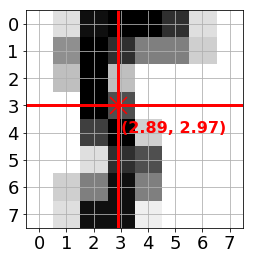

In [24]:
plotImage(digits.images[indices][80], project(digits.images[indices][80]))

In [25]:
print(model.predict_proba([project(digits.images[indices][80])]))

[[1.45378439e-07 9.99999855e-01 8.61493590e-16]]


In [26]:
print(model.predict([project(digits.images[indices][80])]))

[5]


Unser Klassifikator funktioniert also! Nun können wir die Klassifikation für all jene 21 Bilder durchführen, die nicht Teil des Trainingsdatensatzes waren. Und da wir ja die korrekten Klassen in unserem speziellen Datensatz kennen (sie sind in der Variable `digits.target` enthalten) können wir die Güte unseres Klassifikators bewerten. Hierzu berechnen wir einfach für wieviele Bilder in unserem Testdatensatz die Klassifikation falsch ist:

In [27]:
prediction = model.predict(data[training_samples:])
print("Anzahl der Fehler in %d Testbildern: %d" % (data[training_samples:].shape[0],(classes[training_samples:] != prediction).sum()))

Anzahl der Fehler in 21 Testbildern: 1


Das bedeutet, das wir mit Hilfe dieses einfachen Verfahrens die weitaus überwiegende Zahl von Bildern korrekt klassifiziert haben, und zwar mit einem Trainingsdatensatz der aus lediglich 60 Beispielbildern besteht.